# Supply Chain Analysis (Análisis de una Cadena de Suministro)

La base de datos original que utilizo para desarrollar el proyecto se encuentra en el repositorio de la Universidad de Londres. [Link](https://brunel.figshare.com/articles/dataset/Supply_Chain_Logistics_Problem_Dataset/7558679)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, contingency, chisquare
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline

In [2]:
pedidos = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "OrderList")
fletes = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "FreightRates")
costos_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCosts")
capacidad_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCapacities")
productos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "ProductsPerPlant")
clientes_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "VmiCustomers")
puertos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "PlantPorts").iloc[:, :2]

In [3]:
pedidos.columns = ["Pedido", "Fecha", "Puerto de origen", "Transportista", "TPT", "Nivel de servicio", "Envío adelantado [días]", 
                   "Envío tardío [días]", "Cliente", "Producto", "Planta", "Puerto de destino", "Items", "Peso [kg/item]"] #Qué es TPT?

fletes.columns = ["Transportista", "Puerto de origen", "Puerto de destino", "Peso mínimo [kg/item]", "Peso máximo [kg/item]", "Nivel de servicio",
                  "Costo mínimo [USD/kg]", "Tasa de flete [USD/kg]", "Modo de transporte", "Envío [días]", "Tipo de transportista"]

costos_almacenaje.columns = ["Planta", "Costo específico [USD/item]"]
capacidad_almacenaje.columns = ["Planta", "Capacidad [kg/día]"] #En qué unidades está esta capacidad?
productos_por_planta.columns = ["Planta", "Producto"]
clientes_por_planta.columns = ["Planta", "Cliente"]
puertos_por_planta.columns = ["Planta", "Puerto de Origen"]

# Análisis exploratorio de los datos

## Tabla Pedidos

In [4]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Pedido                   9215 non-null   float64       
 1   Fecha                    9215 non-null   datetime64[ns]
 2   Puerto de origen         9215 non-null   object        
 3   Transportista            9215 non-null   object        
 4   TPT                      9215 non-null   int64         
 5   Nivel de servicio        9215 non-null   object        
 6   Envío adelantado [días]  9215 non-null   int64         
 7   Envío tardío [días]      9215 non-null   int64         
 8   Cliente                  9215 non-null   object        
 9   Producto                 9215 non-null   int64         
 10  Planta                   9215 non-null   object        
 11  Puerto de destino        9215 non-null   object        
 12  Items                    9215 non-

*¿En qué fecha se realizaron los pedidos?*

In [111]:
d = pedidos["Fecha"].unique().astype("datetime64[D]").astype(str)
d[0]

#Hay que acomodar la fecha en el formato dd-mm-aaaa

'2013-05-26'

*¿Cuál es el total de pedidos en esa fecha?*

In [94]:
pedidos.shape[0]

9215

*¿Cuántos pedidos hubo por cada conjunto (Planta, Puerto de origen, Puerto de destino)?*

In [164]:
pedidos["Pedido"] = pedidos["Pedido"].astype(int)
lista = ["Puerto de origen", "Planta", "Puerto de destino"]
pedidos[lista] = pedidos[lista].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

In [166]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Pedido": "size"})
pedidos_agrup = pedidos_agrup.rename(columns = {"Pedido": "Recuento"})

total = pedidos_agrup["Recuento"].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup["%"] = pedidos_agrup["Recuento"].apply(porcentaje)
pedidos_agrup.round(2)

,,,Recuento,%
Planta,Puerto de origen,Puerto de destino,,
3,4,9,8541,92.69
4,5,9,1,0.01
8,4,9,102,1.11
9,4,9,12,0.13
12,4,9,300,3.26
13,4,9,86,0.93
16,9,9,173,1.88


*Estadística Descriptiva de los Items para cada conjunto (Planta, Puerto de origen, Puerto de destino)*

In [142]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Items", "sum")].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup[("Items", "%")] = pedidos_agrup[("Items", "sum")].apply(porcentaje)
pedidos_agrup.round(2)

Items                              \
                                            min      mean     max       std   
Planta Puerto de origen Puerto de destino                                     
3      4                9                   235   3349.91  561847  16525.97   
4      5                9                   348    348.00     348       NaN   
8      4                9                   684   2715.76    5680   1504.06   
9      4                9                  2301  18652.50  101069  28877.08   
12     4                9                   236    373.33    1321    169.36   
13     4                9                   240    504.41    5244    609.10   
16     9                9                   280   1416.95    4464   1121.49   

                                                            
                                                sum      %  
Planta Puerto de origen Puerto de destino                   
3      4                9                  28611617  96.94  
4      5                9                       348   0.00  
8      4                9                    277008   0.94  
9      4                9                    223830   0.76  
12     4                9                    112000   0.38  
13     4                9                     43379   0.15  
16     9                9                    245133   0.83

*Estadística Descriptiva de Peso [kg/items] para cada conjunto (Planta, Puerto de origen, Puerto de destino)*

In [139]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Peso [kg/item]": ["min", "mean", "max", "std"]})
pedidos_agrup.round(2)

Peso [kg/item]                   \
                                                     min    mean      max   
Planta Puerto de origen Puerto de destino                                   
3      4                9                           0.00   15.86  1356.76   
4      5                9                           2.10    2.10     2.10   
8      4                9                           2.29   14.50    43.64   
9      4                9                           5.35   33.86   171.92   
12     4                9                           0.26   27.16   325.96   
13     4                9                           0.35   63.12   946.50   
16     9                9                           0.61  185.94  2338.41   

                                                   
                                              std  
Planta Puerto de origen Puerto de destino          
3      4                9                   50.20  
4      5                9                     NaN  
8      4                9                   10.37  
9      4                9                   48.35  
12     4                9                   52.33  
13     4                9                  127.13  
16     9                9                  264.06

*Estadística Descriptiva de Peso [kg] para cada conjunto (Planta, Puerto de origen, Puerto de destino)*

In [138]:
pedidos["Peso [kg]"] = pedidos["Items"] * pedidos["Peso [kg/item]"]
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Peso [kg]": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Peso [kg]", "sum")].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup[("Peso [kg]", "%")] = pedidos_agrup[("Peso [kg]", "sum")].apply(porcentaje)
pedidos_agrup.round(2)

Peso [kg]                            \
                                                min        mean           max   
Planta Puerto de origen Puerto de destino                                       
3      4                9                      0.00   450220.37  3.543400e+08   
4      5                9                    731.19      731.19  7.311900e+02   
8      4                9                   2080.80    54381.49  2.462982e+05   
9      4                9                  12300.18  1904321.00  1.737580e+07   
12     4                9                     87.48    17698.06  3.170878e+05   
13     4                9                     90.88   104671.33  4.963446e+06   
16     9                9                    219.77   417614.22  3.630482e+06   

                                                                            
                                                  std           sum      %  
Planta Puerto de origen Puerto de destino                                   
3      4                9                  6837051.65  3.845332e+09  97.10  
4      5                9                         NaN  7.311900e+02   0.00  
8      4                9                    55826.22  5.546912e+06   0.14  
9      4                9                  4966753.18  2.285185e+07   0.58  
12     4                9                    46996.80  5.309418e+06   0.13  
13     4                9                   543657.14  9.001734e+06   0.23  
16     9                9                   729269.77  7.224726e+07   1.82

*¿Hay alguna correlación entre Recuento de Pedidos e Items?*

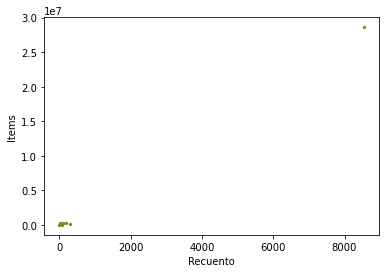

In [167]:
pedidos_agrup1 = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Pedido": "size"})
pedidos_agrup1 = pedidos_agrup1.rename(columns = {"Pedido": "Recuento"})
pedidos_agrup2 = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items": ["min", "mean", "max", "std", "sum"]})

plt.figure(1)
plt.scatter(pedidos_agrup1["Recuento"], pedidos_agrup2[("Items", "sum")], s = 5, c = "olivedrab")
plt.xlabel("Recuento")
plt.ylabel("Items");

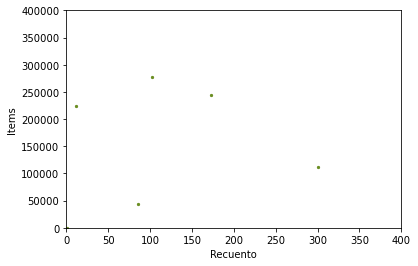

In [162]:
plt.figure(1)
plt.scatter(pedidos_agrup1["Recuento"], pedidos_agrup2[("Items", "sum")], s = 5, c = "olivedrab")
plt.xlabel("Recuento")
plt.ylabel("Items")
plt.xlim(0, 400)
plt.ylim(0, 0.4e6);

#REVISAR

*¿Hay alguna correlación entre Peso [kg/items] e Items?*

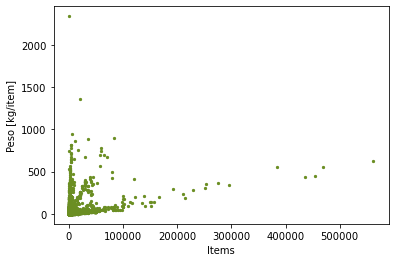

In [150]:
plt.figure(1)
plt.scatter(pedidos["Items"], pedidos["Peso [kg/item]"], s = 5, c = "olivedrab")
plt.xlabel("Items")
plt.ylabel("Peso [kg/item]");

In [122]:
r2, pvalue = pearsonr(x = pedidos["Items"], y = pedidos["Peso [kg/item]"])
round(r2, 3)

0.345

## Tabla Fletes

In [11]:
fletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transportista           1540 non-null   object 
 1   Puerto de origen        1540 non-null   object 
 2   Puerto de destino       1540 non-null   object 
 3   Peso mínimo [kg/item]   1540 non-null   float64
 4   Peso máximo [kg/item]   1540 non-null   float64
 5   Nivel de servicio       1540 non-null   object 
 6   Costo mínimo [USD/kg]   1540 non-null   float64
 7   Tasa de flete [USD/kg]  1540 non-null   float64
 8   Modo de transporte      1540 non-null   object 
 9   Envío [días]            1540 non-null   int64  
 10  Tipo de transportista   1540 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 132.5+ KB


In [210]:
lista = ["Puerto de origen", "Puerto de destino"]
fletes[lista] = fletes[lista].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)
fletes["Modo de transporte"] = fletes["Modo de transporte"].replace({"AIR   ": "Aire", "GROUND": "Tierra"}, regex = True)

*Estadística Descriptiva de Tasa de flete [USD/kg] para cada conjunto (Puerto de origen, Puerto de destino)*

In [211]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Tasa de flete [USD/kg]": ["min", "mean", "max", "std"]})
fletes_agrup.round(2)

Tasa de flete [USD/kg]                     
                                                      min  mean     max    std
Puerto de origen Puerto de destino                                            
2                9                                   0.05  1.87    7.06   1.78
3                9                                   0.12  9.98  128.03  19.30
4                9                                   0.04  1.94    7.66   2.05
5                9                                   0.07  2.87   12.07   2.90
6                9                                   0.07  2.53    7.16   1.74
7                9                                   0.14  0.20    0.28   0.04
8                9                                   0.10  0.59    1.83   0.56
9                9                                   0.03  2.84   21.28   6.59
10               9                                   0.10  5.37   18.96   4.99
11               9                                   0.07  0.13    0.34   0.06

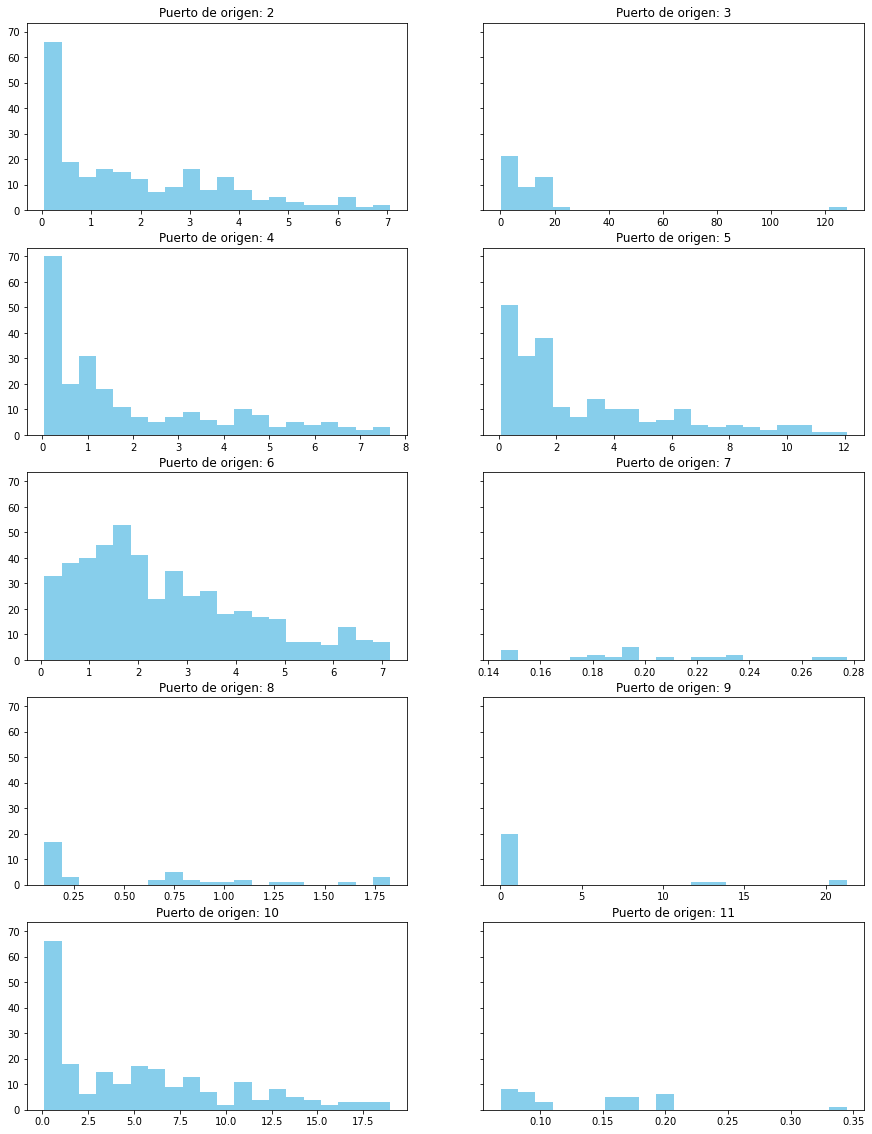

In [234]:
nrows = 5
ncols = 2

puerto_origen = fletes_agrup.index.levels[0].values
puerto_origen = puerto_origen[: nrows*ncols].reshape(nrows, ncols)

fig, ax = plt.subplots(nrows, ncols, figsize = (15, 20), sharey = True)
for i in range(nrows):
    for j in range(ncols):
        mask = fletes["Puerto de origen"] == puerto_origen[i, j]
        ax[i, j].set_title("Puerto de origen: {}".format(puerto_origen[i, j]))
        ax[i, j].hist(fletes.loc[mask, "Tasa de flete [USD/kg]"], bins = 20, color = "skyblue");

In [226]:
#Al ser la Tasa de Flete una variable continua se podría implementar una tabla con pd.cut

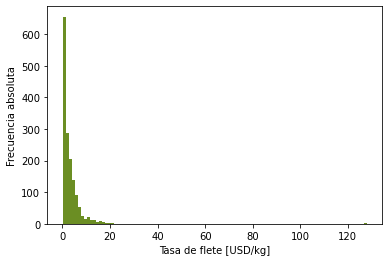

In [13]:
plt.figure(1)
plt.hist(fletes["Tasa de flete [USD/kg]"], bins = 100, color = "olivedrab")
plt.xlabel("Tasa de flete [USD/kg]")
plt.ylabel("Frecuencia absoluta");

#Ajustar el rango de x

In [169]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Envío [días]": ["min", "mean", "max", "size"]})
fletes_agrup.round(2)

Envío [días]               
                                            min  mean max size
Puerto de origen Puerto de destino                            
2                9                            0  1.62  14  226
3                9                            0  2.91  14   45
4                9                            0  1.58  14  231
5                9                            1  1.27   4  219
6                9                            1  1.99   3  479
7                9                            3  4.50   6   20
8                9                            2  4.82  14   39
9                9                            0  4.42  14   24
10               9                            2  3.17   6  222
11               9                            0  5.29  14   35

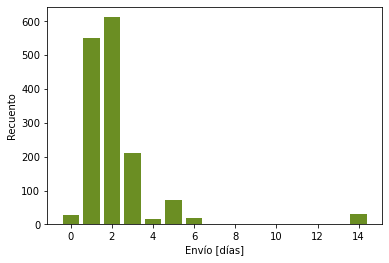

In [15]:
fletes_agrup = fletes.groupby(by = "Envío [días]").agg({"Envío [días]": "size"}).rename(columns = {"Envío [días]": "Recuento"})

plt.figure(1)
plt.bar(x = fletes_agrup.index, height = fletes_agrup["Recuento"], color = "olivedrab")
plt.xlabel("Envío [días]")
plt.ylabel("Recuento");

In [16]:
variacion = fletes_agrup["Recuento"].max() - fletes_agrup["Recuento"].min()
variacion

597

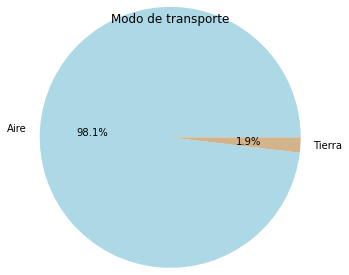

In [171]:
fletes_agrup = fletes.groupby(by = "Modo de transporte").agg({"Puerto de origen": "size"})
fletes_agrup = fletes_agrup.rename(columns = {"Puerto de origen": "Recuento de Puerto de origen"})

plt.figure(1)
plt.title("Modo de transporte")
plt.pie(x = fletes_agrup["Recuento de Puerto de origen"], labels = fletes_agrup.index, radius = 1.5, autopct = "%1.1f%%", colors = ["lightblue", "tan"]);

## Tabla Costos de Almacenaje

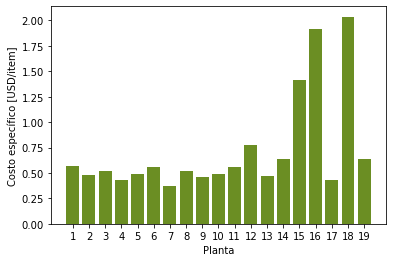

In [18]:
costos_almacenaje["Planta"] = costos_almacenaje["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

plt.figure(1)
plt.bar(x = costos_almacenaje["Planta"], height = costos_almacenaje["Costo específico [USD/item]"], color = "olivedrab")
plt.xlabel("Planta")
plt.xticks(costos_almacenaje["Planta"])
plt.ylabel("Costo específico [USD/item]");

In [19]:
variacion = costos_almacenaje["Costo específico [USD/item]"].max() - costos_almacenaje["Costo específico [USD/item]"].min()
round(variacion, 2)

1.66

## Tabla Capacidad de Almacenaje

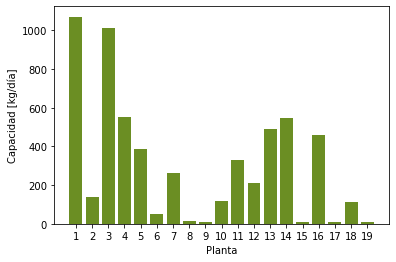

In [20]:
capacidad_almacenaje["Planta"] = capacidad_almacenaje["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

plt.figure(1)
plt.bar(x = capacidad_almacenaje["Planta"], height = capacidad_almacenaje["Capacidad [kg/día]"], color = "olivedrab")
plt.xlabel("Planta")
plt.xticks(capacidad_almacenaje["Planta"])
plt.ylabel("Capacidad [kg/día]");

In [21]:
variacion = capacidad_almacenaje["Capacidad [kg/día]"].max() - capacidad_almacenaje["Capacidad [kg/día]"].min()
variacion

1063

## Tabla Productos por cada Planta

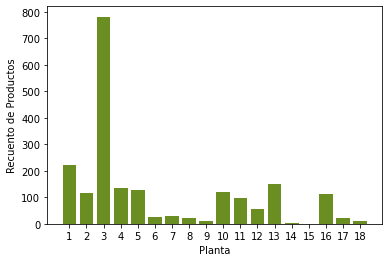

In [22]:
productos_por_planta["Planta"] = productos_por_planta["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)
productos_agrup_por_planta = productos_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Productos"})

plt.figure(1)
plt.bar(x = productos_agrup_por_planta.index, height = productos_agrup_por_planta["Recuento de Productos"], color = "olivedrab")
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Productos");

In [23]:
variacion = productos_agrup_por_planta["Recuento de Productos"].max() - productos_agrup_por_planta["Recuento de Productos"].min()
variacion

780

## Tabla Clientes por cada Planta

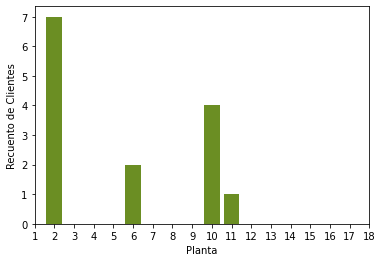

In [24]:
clientes_por_planta["Planta"] = clientes_por_planta["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)
clientes_agrup_por_planta = clientes_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Clientes"})

plt.figure(1)
plt.bar(x = clientes_agrup_por_planta.index, height = clientes_agrup_por_planta["Recuento de Clientes"], color = "olivedrab")
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Clientes");

In [219]:
variacion = clientes_agrup_por_planta["Recuento de Clientes"].max() - clientes_agrup_por_planta["Recuento de Clientes"].min()
variacion

6

## Tabla Puertos por cada Planta

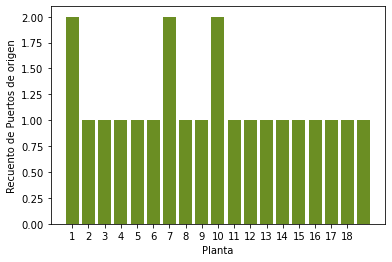

In [25]:
puertos_por_planta[["Planta", "Puerto de Origen"]] = puertos_por_planta[["Planta", "Puerto de Origen"]].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)
puertos_agrup_por_planta = puertos_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Puertos de origen"})

plt.figure(1)
plt.bar(x = puertos_agrup_por_planta.index, height = puertos_agrup_por_planta["Recuento de Puertos de origen"], color = "olivedrab")
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Puertos de origen");

In [28]:
puertos_por_planta_pivot = puertos_por_planta.pivot_table(index = "Planta", columns = "Puerto de Origen", aggfunc = "size").fillna(0).astype(int)
puertos_por_planta_pivot.head()

Puerto de Origen,1,2,3,4,5,6,7,8,9,10,11
Planta,,,,,,,,,,,
1,1,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0


In [29]:
datos_observados = puertos_por_planta_pivot
datos_esperados = stats.contingency.expected_freq(datos_observados)
resultados = chisquare(datos_observados, datos_esperados, axis = None) #Estadístico Chi Cuadrado

resultados.statistic, resultados.pvalue #Puede haber una correlacción significativo !!!

NameError: name 'stats' is not defined

## Tabla Completa

**Función Objetivo**\
Se desea conocer un conjunto de plantas de almacenaje, puertos de origen y puertos de destino que minimicen el costo total de la cadena de suministro. 
Matematicamente, se trata de un problema de optimización.

Costo total = Costo de almacenaje + Costo de transporte

El cliente decide qué nivel de servicio requiere:
- DTD: Puerta a Puerta (Door To Door)
- DTP: Puerta a Puerto (Door To Port)
- CRF: Carga Referida por el Cliente (Customer Referred Freight)

*Suposiciones:*

-
-
-
-


*Estadística Descriptiva del Costo de Almacenaje*

In [67]:
df1 = pd.merge(pedidos, fletes, on = ["Puerto de origen", "Puerto de destino", "Transportista", "Nivel de servicio"])
df2 = pd.merge(df1, costos_almacenaje, on = ["Planta"])
df3 = pd.merge(df2, capacidad_almacenaje, on = ["Planta"])

df3["Costo de almacenaje [USD]"] = df3["Items"] * df3["Costo específico [USD/item]"]
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo de almacenaje [USD]": ["min", "mean", "max", "sum"]}).round(2)
df3_agrup

Costo de almacenaje [USD]           \
                                                                min     mean   
Planta Puerto de origen Puerto de destino                                      
3      4                9                                    121.61  1170.68   
8      4                9                                    357.63  1430.16   
9      4                9                                   1070.13  8674.74   
12     4                9                                    182.46   291.55   
13     4                9                                    112.73   236.92   
16     9                9                                    539.47   703.10   

                                                                    
                                                 max           sum  
Planta Puerto de origen Puerto de destino                           
3      4                9                  290756.89  1.613191e+08  
8      4                9                    2969.83  1.444466e+06  
9      4                9                   47004.27  1.040969e+06  
12     4                9                    1021.31  1.862992e+06  
13     4                9                    2463.14  2.037542e+05  
16     9                9                    1581.92  2.390544e+04

In [61]:
pd.DataFrame(data = df3_agrup[("Costo de almacenaje [USD]", "sum")].describe())

,Costo de almacenaje [USD]
,sum
count,6.000000e+00
mean,2.764920e+07
std,6.548842e+07
min,2.390544e+04
25%,4.130578e+05
50%,1.242718e+06
75%,1.758361e+06
max,1.613191e+08


*Estadística Descriptiva del Costo de Transporte*

In [69]:
df3["Costo de transporte [USD]"] = np.where(df3["Nivel de servicio"] == "CRF", 0, df3["Items"] * df3["Peso [kg/item]"] * df3["Tasa de flete [USD/kg]"])
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo de transporte [USD]": ["min", "mean", "max", "sum"]}).round(2)
df3_agrup

Costo de transporte [USD]  \
                                                                min   
Planta Puerto de origen Puerto de destino                             
3      4                9                                      0.00   
8      4                9                                     88.23   
9      4                9                                    521.53   
12     4                9                                      3.71   
13     4                9                                      3.85   
16     9                9                                   2698.44   

                                                                   \
                                                mean          max   
Planta Puerto de origen Puerto de destino                           
3      4                9                   16635.35  17150058.30   
8      4                9                    2392.90     11920.83   
9      4                9                   83028.40    840988.85   
12     4                9                    2735.21     98032.14   
13     4                9                    4563.67    240230.79   
16     9                9                  583942.84   9561053.88   

                                                         
                                                    sum  
Planta Puerto de origen Puerto de destino                
3      4                9                  2.292351e+09  
8      4                9                  2.416832e+06  
9      4                9                  9.963407e+06  
12     4                9                  1.747802e+07  
13     4                9                  3.924756e+06  
16     9                9                  1.985406e+07

In [65]:
pd.DataFrame(data = df3_agrup[("Costo de transporte [USD]", "sum")].describe())

,Costo de transporte [USD]
,sum
count,6.000000e+00
mean,3.909980e+08
std,9.314951e+08
min,2.416832e+06
25%,5.434419e+06
50%,1.372071e+07
75%,1.926005e+07
max,2.292351e+09


*Estadística Descriptiva del Costo Total*

In [32]:
df3["Costo total [USD]"] = df3["Costo de almacenaje [USD]"] + df3["Costo de transporte [USD]"]
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo total [USD]": ["min", "mean", "max", "sum"]}).round(2)
df3_agrup

Costo total [USD]             \
                                                        min       mean   
Planta Puerto de origen Puerto de destino                                
3      4                9                            121.72   17806.02   
8      4                9                            445.86    3823.07   
9      4                9                           1591.66   91703.13   
12     4                9                            192.14    3026.76   
13     4                9                            121.62    4800.59   
16     9                9                           3385.73  584645.94   

                                                                      
                                                   max           sum  
Planta Puerto de origen Puerto de destino                             
3      4                9                  17440815.18  2.453670e+09  
8      4                9                     14871.84  3.861298e+06  
9      4                9                    887993.12  1.100438e+07  
12     4                9                     98823.05  1.934101e+07  
13     4                9                    242693.93  4.128510e+06  
16     9                9                   9561693.17  1.987796e+07

In [163]:
df3_agrup.describe().round(2)

Costo total [USD]                                      
                    min       mean          max           sum
count              6.00       6.00         6.00  6.000000e+00
mean             976.45  117634.25   4707815.05  4.186472e+08
std             1306.99  231325.45   7259260.22  9.969779e+08
min              121.62    3026.76     14871.84  3.861298e+06
25%              139.32    4067.45    134790.77  5.847477e+06
50%              319.00   11303.31    565343.52  1.517269e+07
75%             1305.21   73228.86   7393268.16  1.974372e+07
max             3385.73  584645.94  17440815.18  2.453670e+09

In [95]:
#idx = pd.IndexSlice
#df3_agrup.loc[idx[:, 4, 9], :]